# 0. Library Import

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import time
import cv2
import random
import gc
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import SimpleITK as sitk
import pydicom as dcm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import *
from torchvision.transforms import Compose

from torch.utils.data import Dataset, ConcatDataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
CFG={'Image_Size':256,
    'EPOCHS':100,
    'BATCH_SIZE':4,
    'Learning_rate':1e-3,
    'beta_1':0.9,
    'beta_2':0.99,
    'eps':0.00000001,
     'weight_decay':0.000001,
    'Channel_size':8,
    'SEED':42}

Number_of_aug=3

In [3]:
warnings.filterwarnings('ignore')

# 1. Check GPU Server

In [4]:
if torch.cuda.is_available():
    device="cuda"
else:
    device="cpu"
    
print(f"device  : {device}")

device  : cuda


In [5]:
print(f"Name of the graphic card : {torch.cuda.get_device_name(0)}")
print(f"Number of gpu : {torch.cuda.device_count()}")

Name of the graphic card : NVIDIA GeForce RTX 4090
Number of gpu : 2


### Seed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=True

seed_everything(CFG['SEED'])

# 2. Get Data Path (T1+T2)

#### Train and Val

In [89]:
Image_Type=['SPGR_P','MAGIC_T2']
Class=['ASD','CONTROL']

e=[3564,3278,3395,3466,3624,3603,3632,3663]

test_asd=[537,571,1856,2071,2126,2886,2922,3207,3488,3519,3565,4026,4047,4109,4270,4355,4396,4681,4740,4806,4881,4887,4916,5023,'s4-107']
test_control=[569,638,1825,1928,2235,3390,3650,3834,3979,4582,4623,4629,4931,5190,5776,5933,5945,'s4-98','s4-102']

In [8]:
#ASD
asd_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\'
asd_patient=os.listdir(asd_path)

all_image_path=[]

for n in asd_patient:
    p=n
    n=n.split('_')[0]
    try:
        n=int(n)
    except:
        n=n
    if n in e or n in test_asd:
        pass
    else:
        personal=[]
        for image in Image_Type:
            path=asd_path+p+'\\'
            path=path+'aNew\\'+image+'\\'
            personal.append(path)
        
        all_image_path.append(personal)

asd=len(all_image_path)
print(f"Number of ASD patient : {len(all_image_path)}")

#Control
control_path='C:\\Users\\PC00\\Desktop\\ASD_data\\CONTROL\\'
control_patient=os.listdir(control_path)

for n in control_patient:
    p=n
    n=n.split('_')[0]
    
    try:
        n=int(n)
    except:
        n=n
    
    if n in test_control:
        pass
    else:
        personal=[]
        for image in Image_Type:
            path=control_path+p+'\\'
            path=path+'aNew\\'+image+'\\'
            personal.append(path)

        all_image_path.append(personal)
    
print(f"Number of CONTROL patient : {len(all_image_path)-asd}")
print(f"Number of Total patient : {len(all_image_path)}")

Number of ASD patient : 188
Number of CONTROL patient : 49
Number of Total patient : 237


In [9]:
#Label
#Train
label=np.array([1]*asd+[0]*(len(all_image_path)-asd), dtype=np.int64)

In [10]:
print(len(label))

237


In [11]:
n=np.unique(label, axis=0)
n=n.shape[0]

label=np.eye(n)[label]
print(label)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

#### Test

In [88]:
test_asd

25

In [90]:
#ASD
asd_path='C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\'
asd_patient=os.listdir(asd_path)

test_image_path=[]

for n in asd_patient:
    p=n
    n=n.split('_')[0]
    try:
        n=int(n)
    except:
        n=n
    
    if n in test_asd:
        personal=[]
        for image in Image_Type:
            path=asd_path+p+'\\'
            path=path+'aNew\\'+image+'\\'
            personal.append(path)

        test_image_path.append(personal)
        
tasd=len(test_image_path)
print(f"Number of Test ASD patient : {len(test_image_path)}")

#Control
control_path='C:\\Users\\PC00\\Desktop\\ASD_data\\CONTROL\\'
control_patient=os.listdir(control_path)

for n in control_patient:
    p=n
    n=n.split('_')[0]
    
    try:
        n=int(n)
    except:
        n=n
    
    if n in test_control:
        personal=[]
        for image in Image_Type:
            path=control_path+p+'\\'
            path=path+'aNew\\'+image+'\\'
            personal.append(path)
        
        test_image_path.append(personal)
    
print(f"Number of Test CONTROL patient : {len(test_image_path)-tasd}")
print(f"Number of Total Test patient : {len(test_image_path)}")

Number of Test ASD patient : 25
Number of Test CONTROL patient : 19
Number of Total Test patient : 44


In [91]:
test_image_path

[['C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\1856_CJW\\aNew\\SPGR_P\\',
  'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\1856_CJW\\aNew\\MAGIC_T2\\'],
 ['C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2071_LWH\\aNew\\SPGR_P\\',
  'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2071_LWH\\aNew\\MAGIC_T2\\'],
 ['C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2126_SES\\aNew\\SPGR_P\\',
  'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2126_SES\\aNew\\MAGIC_T2\\'],
 ['C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2886_LSM\\aNew\\SPGR_P\\',
  'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2886_LSM\\aNew\\MAGIC_T2\\'],
 ['C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2922_JJW\\aNew\\SPGR_P\\',
  'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\2922_JJW\\aNew\\MAGIC_T2\\'],
 ['C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\3207_KHK\\aNew\\SPGR_P\\',
  'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\3207_KHK\\aNew\\MAGIC_T2\\'],
 ['C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\3488_KSW\\aNew\\SPGR_P\\',
  'C:\\Users\\PC00\\Desktop\\ASD_data\\ASD\\3488_KSW\\aNew\

In [13]:
#Label Test
test_label=np.array([1]*tasd+[0]*(len(test_image_path)-tasd), dtype=np.int64)

In [14]:
print(len(test_label))

44


In [15]:
n=np.unique(test_label, axis=0)
n=n.shape[0]

test_label=np.eye(n)[test_label]
print(test_label)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# 3. Train and Val

In [16]:
train_path, val_path, train_label, val_label=train_test_split(all_image_path, label, test_size=0.3, random_state=CFG['SEED'])

In [17]:
print(len(train_path), len(val_path), len(train_label), len(val_label))

165 72 165 72


### For augmentation call Control path

In [18]:
# all_image_path
#train_path중 TC만 살짝 빼기
aug_image_path=[]

for p in train_path:
    for q in p:
        if 'CONTROL' in q:
            aug_image_path.append(p)
        
print(len(aug_image_path)//2)

33


In [19]:
#val_path중 TC만 살짝 빼기
sample_vtc=[]

for p in val_path:
    for q in p:
        if 'CONTROL' in q:
            sample_vtc.append(p)
        
print(len(sample_vtc)//2)

16


In [20]:
aug_label=np.array([1,0]*(len(aug_image_path)//2) ,dtype=np.float64)
aug_label=np.reshape(aug_label, (-1, 2))

In [21]:
len(aug_label)

33

In [22]:
aug_label[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [23]:
train_asd=0
train_tc=0
for path in train_path:
    for q in path:
        if 'CONTROL' in q:
            train_tc+=1

train_tc=train_tc//2
train_asd=len(train_path)-train_tc      
print("Train ASD : ", train_asd)
print("Train TC : ", train_tc+(train_tc*Number_of_aug))

Train ASD :  132
Train TC :  132


In [24]:
val_asd=0
val_tc=0
for path in val_path:
    for q in path:
        if 'CONTROL' in q:
            val_tc+=1
    
val_tc=val_tc//2
val_asd=len(val_path)-val_tc      
print("Val ASD : ", val_asd)
print("Val TC : ", val_tc)

Val ASD :  56
Val TC :  16


# 4. Transfomration and Augmentation

### Transform

Resize

In [25]:
pad_image=[[0]*256]*256

In [26]:
def T1_resize(img_volume, plus_image):
    #(256, 256, 188)
    
    want_channel=188
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    #차이가 짝수이면
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

In [27]:
def T2_resize(img_volume, plus_image):
    #(256, 256, 34)
    
    want_channel=34
    original_channel=img_volume.shape[0]
    difference=abs(want_channel-original_channel)
  
    if difference==0:
        return img_volume
    else:
        img_volume=list(img_volume)
        #차이가 짝수이면
        if difference%2==0:
            #front & behind
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)
        
        else:
            #front
            for _ in range(difference//2):
                img_volume.insert(0, plus_image)
            #behind    
            for _ in range(difference//2+1):
                img_volume.insert(len(img_volume), plus_image)
                
            return np.array(img_volume)

Cropping

In [28]:
def T1_crop(img_volume):
    area=(45, 45, 215, 215)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i]
    
        img=Image.fromarray(np.uint16(img))

        img=img.crop(area)
        
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

In [29]:
def T2_crop(img_volume):
    area=(40, 40, 225, 225)
    img_crop_volume=[]
    for i in range(img_volume.shape[0]):
        img=img_volume[i]
    
        img=Image.fromarray(np.uint16(img))

        img=img.crop(area)
        
        img=np.array(img)
        img=list(img)
        img_crop_volume.append(img)
  
    img_crop_volume=np.array(img_crop_volume)
    return img_crop_volume

MinMaxScaler

In [30]:
class MinMaxScaler3D(MinMaxScaler):
    def fit_transform(self, X,y=None):
        x=np.reshape(X, newshape=(X.shape[0]*X.shape[1], X.shape[2]))
        return np.reshape(super().fit_transform(x, y=y), newshape=X.shape)

In [31]:
scaler = MinMaxScaler3D()

### Augmentation

horizontal

In [32]:
def horizontal_flip(img_volume):
    s=torchvision.transforms.functional.hflip(torch.Tensor(img_volume))
    return np.array(s)

vertical

In [33]:
def vertical_flip(img_volume):
    s=torchvision.transforms.functional.vflip(torch.Tensor(img_volume))
    return np.array(s)

rotate

In [34]:
def rotate(img_volume, angle):
    s=torchvision.transforms.functional.rotate(torch.Tensor(img_volume), angle)
    return np.array(s)

example

In [35]:
a=np.random.randint(0,len(aug_image_path))
print(a)

51


# 5. Get Image From Data Path

In [36]:
def convert_to_numpy(sitk_volume, size):
    """convert sitk image to numpy volume"""
    img_volume = sitk.GetArrayFromImage(sitk_volume)
    img_volume = img_volume.transpose(2,1,0)
    #print(img_volume.shape)
    if img_volume.shape[0]!=CFG['Image_Size']:
        img_volume = cv2.resize(img_volume, dsize=(CFG['Image_Size'], CFG['Image_Size']))
    
    #img_volume = img_volume.transpose(1,2,0)
    
    return img_volume

In [37]:
def get_image(path):
    reader=sitk.ImageSeriesReader()
    dicom_names=reader.GetGDCMSeriesFileNames(path)
    
    #print("Number of Series : ", len(dicom_names))
    
    reader.SetFileNames(dicom_names)
    
    image=reader.Execute()
    size=image.GetSize()
    #print("Original size of series : ", size[0], size[1], size[2])
    img_volume=convert_to_numpy(image, size)
    
    img_volume=img_volume.transpose(2,1,0)
    
    if 'SPGR_P' in path:
        img_volume=T1_resize(img_volume, pad_image)
        img_volume=T1_crop(img_volume)
    elif 'MAGIC_T2' in path:
        img_volume=T2_resize(img_volume, pad_image)
        img_volume=T2_crop(img_volume)
    #print("Convert size of series : ", img_volume.shape[0], img_volume.shape[1], img_volume.shape[2])
    img_volume = scaler.fit_transform(img_volume)
    return img_volume

In [38]:
#(?,256,256)
def rescale_size(img_volume):   
    img=img_volume.transpose(2,1,0)
    img=cv2.resize(img, (256,256))
    img_volume=img.transpose(2,1,0)
    
    return img_volume

# 6. CustomDataset

In [39]:
def for_dataset_image(path, aug=None, angle=None, type=None):
    img=get_image(path)

    if aug=='horizontal':
        img=horizontal_flip(img)
    elif aug=='vertical':
        img=vertical_flip(img)
    elif aug=='rotate':
        img=rotate(img, angle)

    if type=='T1':
        img=img[40:140]
    
    img=rescale_size(img)
    img=torch.from_numpy(img)
    img=torch.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2]))

    return img

In [40]:
#Not augmentation customdataset
class CustomDataset(Dataset):
    def __init__(self, path,labels, transforms=None):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.transforms=transforms
        
    def __getitem__(self, idx):
        #add label
        state=self.labels[idx]
        state=state.cuda()
        
        image_T1_path=self.path[idx][0]
        image_T2_path=self.path[idx][1]
        
        image_T1=for_dataset_image(image_T1_path, None, None, 'T1')
        image_T2=for_dataset_image(image_T2_path)
        
        image_T1=image_T1.cuda()
        image_T2=image_T2.cuda()
 
        return image_T1, image_T2, state
        
    def __len__(self):
        return len(self.labels)   

In [41]:
# horizontal customdataset
class Horizontal_Dataset(Dataset):
    def __init__(self, path,labels, transforms=None):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.transforms=transforms
        
    def __getitem__(self, idx):
        #add label
        state=self.labels[idx]
        state=state.cuda()
        
        image_T1_path=self.path[idx][0]
        image_T2_path=self.path[idx][1]
        
        image_T1=for_dataset_image(image_T1_path, 'horizontal', None, 'T1')
        image_T2=for_dataset_image(image_T2_path, 'horizontal')
        
        image_T1=image_T1.cuda()
        image_T2=image_T2.cuda()
 
        return image_T1, image_T2, state
        
    def __len__(self):
        return len(self.labels)  

In [42]:
#vertical customdataset
# horizontal customdataset
class Vertical_Dataset(Dataset):
    def __init__(self, path,labels, transforms=None):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.transforms=transforms
        
    def __getitem__(self, idx):
        #add label
        state=self.labels[idx]
        state=state.cuda()
        
        image_T1_path=self.path[idx][0]
        image_T2_path=self.path[idx][1]
        
        image_T1=for_dataset_image(image_T1_path, 'horizontal', None, 'T1')
        image_T2=for_dataset_image(image_T2_path, 'vertical')
        
        image_T1=image_T1.cuda()
        image_T2=image_T2.cuda()
 
        return image_T1, image_T2, state
        
    def __len__(self):
        return len(self.labels)    

In [43]:
#rotate customdataset
class Rotate_Dataset(Dataset):
    def __init__(self, path,labels, angle,transforms=None):
        self.path=path
        self.labels=torch.from_numpy(labels)
        self.transforms=transforms
        self.angle=angle
        
    def __getitem__(self, idx):
        #add label
        state=self.labels[idx]
        state=state.cuda()
        
        image_T1_path=self.path[idx][0]
        image_T2_path=self.path[idx][1]
        
        image_T1=for_dataset_image(image_T1_path, 'rotate', self.angle, 'T1')
        image_T2=for_dataset_image(image_T2_path, 'rotate', self.angle)
        
        image_T1=image_T1.cuda()
        image_T2=image_T2.cuda()
 
        return image_T1, image_T2, state
        
    def __len__(self):
        return len(self.labels)   

In [44]:
horizontal_data=Horizontal_Dataset(aug_image_path, aug_label)
vertical_data=Horizontal_Dataset(aug_image_path, aug_label)

In [45]:
a=np.random.randint(0,90)
print(f"rotate angle : {a}")
rotate_data=Rotate_Dataset(aug_image_path, aug_label, a)

rotate angle : 14


In [92]:
train_data=CustomDataset(train_path, train_label)
val_data=CustomDataset(val_path, val_label)

test_data=CustomDataset(test_image_path, test_label) # 나중에 augmentation할 때 적용 하면 안됨

In [47]:
n=random.randint(0,len(train_label))
print(f"Original dataset random index : {n}")

aug=random.randint(0, len(aug_label))
print(f"Aug dataset random index : {aug}")

Original dataset random index : 163
Aug dataset random index : 7


In [48]:
print(f"Original dataset shape          T1 : {train_data.__getitem__(n)[0].shape} {type(train_data.__getitem__(n)[0])} T2 : {train_data.__getitem__(n)[1].shape} {type(train_data.__getitem__(n)[1])}")
print(f"----------Aug Dataset----------")
print(f"Horizontal flip dataset shape   T1 : {horizontal_data.__getitem__(aug)[0].shape} {type(horizontal_data.__getitem__(aug)[0])} T2 : {horizontal_data.__getitem__(aug)[1].shape} {type(horizontal_data.__getitem__(aug)[1])}")
print(f"Vertical flip dataset shape     T1 : {vertical_data.__getitem__(aug)[0].shape} {type(vertical_data.__getitem__(aug)[0])} T2 : {vertical_data.__getitem__(aug)[1].shape} {type(vertical_data.__getitem__(aug)[1])}")
print(f"Rotate dataset shape            T1 : {rotate_data.__getitem__(aug)[0].shape} {type(rotate_data.__getitem__(aug)[0])} T2 : {rotate_data.__getitem__(aug)[1].shape} {type(rotate_data.__getitem__(aug)[1])}")

Original dataset shape          T1 : torch.Size([1, 100, 256, 256]) <class 'torch.Tensor'> T2 : torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>
----------Aug Dataset----------
Horizontal flip dataset shape   T1 : torch.Size([1, 100, 256, 256]) <class 'torch.Tensor'> T2 : torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>
Vertical flip dataset shape     T1 : torch.Size([1, 100, 256, 256]) <class 'torch.Tensor'> T2 : torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>
Rotate dataset shape            T1 : torch.Size([1, 100, 256, 256]) <class 'torch.Tensor'> T2 : torch.Size([1, 34, 256, 256]) <class 'torch.Tensor'>


In [49]:
aug_dataset=ConcatDataset([horizontal_data, vertical_data, rotate_data])
train_data=ConcatDataset([train_data, aug_dataset])

In [50]:
print(len(train_data))

264


In [93]:
train_dataloader=DataLoader(train_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)
validation_dataloader=DataLoader(val_data, batch_size=CFG['BATCH_SIZE'], shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=CFG['BATCH_SIZE'],shuffle=True)

In [52]:
train_features_T1, train_features_T2, train_labels=next(iter(train_dataloader))

In [53]:
print(train_labels)

tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.]], device='cuda:0', dtype=torch.float64)


# 7. Model

## 3D CS ResNet Model = 3D ResNet + CS Block

### CS Block

In [54]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max']):
        super(ChannelGate, self).__init__()
        self.gate_channels=gate_channels
        self.mlp=nn.Sequential(
                        Flatten(),
                        nn.Linear(gate_channels, gate_channels // reduction_ratio),
                        nn.ReLU(),
                        nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types=pool_types
        
    def forward(self, x):
        channel_att_sum=None
        #print("Input of Channel gate shape : ", x.size(0), x.size(1), x.size(2), x.size(3)) # 8 64 17 64 64
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool3d( x, (x.size(2), x.size(3), x.size(4)), stride=(x.size(2), x.size(3), x.size(4)))
                channel_att_raw = self.mlp( lp_pool )
                
            if channel_att_sum is None:
                channel_att_sum=channel_att_raw
            else:
                channel_att_sum=channel_att_sum+channel_att_raw
                
        scale = F.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).unsqueeze(4).expand_as(x)
        return x*scale

In [55]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm3d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

In [56]:
class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size=7
        self.compress=ChannelPool()
        self.spatial=BasicConv(2,1, kernel_size, stride=1, padding=(kernel_size-1)//2, relu=False)
        
    def forward(self, x):
        x_compress=self.compress(x)
        x_out=self.spatial(x_compress)
        scale=F.sigmoid(x_out) #broadcasting
        return x*scale

In [57]:
class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg','max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate=ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate=SpatialGate()
            
    def forward(self, x):
        x_out=self.ChannelGate(x)
        if not self.no_spatial:
            x_out=self.SpatialGate(x_out)
            
        return x_out

### 3D ResNet Model

In [58]:
def get_inplanes():
    return [64, 128, 256, 512]

def conv3x3x3(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=3,
                     stride=stride,
                     padding=1,
                     bias=False)

def conv1x1x1(in_planes, out_planes, stride=1):
    return nn.Conv3d(in_planes,
                     out_planes,
                     kernel_size=1,
                     stride=stride,
                     bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, CBAM_use=False):
        super().__init__()

        self.conv1 = conv3x3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.downsample = downsample
        self.stride = stride
        self.dropout=nn.Dropout(0.5)
        
        if CBAM:
            self.cbam=CBAM(planes, 16)
        else:
            self.cbam=None

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.dropout(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)
            
        if not self.cbam is None:
            out=self.cbam(out)

        out += residual
        out = self.relu(out)
        
        return out

In [59]:
class ResNet18(nn.Module):
    def __init__(self, 
                 block, #Basicblock
                 layers, #[2,2,2,2]
                 block_inplanes, #[64, 128, 256, 512]
                 in_channels, #1
                 out_channels, #64
                 shortcut_type='B',
                 att_type=None,
                 stride=2, 
                 n_classes=2): #1, 64
        super().__init__()

        self.in_planes=block_inplanes[0]
        self.no_max_pool=False

        self.conv1=nn.Conv3d(in_channels, self.in_planes, kernel_size=(7,7,7), stride=(1,2,2), padding=(7//2,3,3), bias=False)
        self.bn1=nn.BatchNorm3d(out_channels)
        self.relu=nn.ReLU(inplace=True) #? -> 기존의 데이터를 연산의 결괏값으로 대체하는 것
        self.maxpool=nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layer1=self._make_layer(block, block_inplanes[0], layers[0], shortcut_type)
        self.layer2=self._make_layer(block, block_inplanes[1], layers[1], shortcut_type, stride=2)
        self.layer3=self._make_layer(block, block_inplanes[2], layers[2], shortcut_type, stride=2)
        self.layer4=self._make_layer(block, block_inplanes[3], layers[3], shortcut_type, stride=2)

        self.avgpool = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc=nn.Linear(block_inplanes[3]*block.expansion, n_classes)
        self.sigmoid=torch.nn.Sigmoid()
        self.log_softmax=torch.nn.LogSoftmax()
        self.softmax=torch.nn.Softmax()
        
        if att_type=='BAM':
            self.bam1=BAM(64*block.expansion)
            self.bam2=BAM(128*block.expansion)
            self.bam3=BAM(256*block.expansion)
        else:
            self.bam1, self.bam2, self.bam3=None, None, None
        
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # He initialization
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1) # 초기값  설정
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, shortcut_type, stride=1):
        downsample=None
        if stride!=1 or self.in_planes != planes*block.expansion:
            if shortcut_type=='A':
                downsample=partial(self._dwonsample_basic_block, planes=planes * block.expansion, stride=stride)
            else:
                downsample=nn.Sequential(
                    conv1x1x1(self.in_planes, planes*block.expansion, stride),
                    nn.BatchNorm3d(planes*block.expansion),
                )

        layers=[]
        layers.append(
            block(in_planes=self.in_planes, planes=planes, stride=stride, downsample=downsample, CBAM_use=True),
        )
        

        self.in_planes=planes*block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes, CBAM_use=True))

        return nn.Sequential(*layers)

    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        if not self.no_max_pool:
            x=self.maxpool(x)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        #여기서 특징추출
        #print(f"Shape of feature : {x.shape}")
    
        return x

In [60]:
class feature_model(nn.Module):
    def __init__(self, 
                resnet, 
                block, #BasicBlock
                block_inplanes, #[64, 128, 256, 512]
                n_classes=2):
        super().__init__()
        self.resnet=resnet(block, [2,2,2,2], block_inplanes, 1, 64)
        self.avgpool = nn.AdaptiveAvgPool3d((1,1,1))
        self.fc=nn.Linear(block_inplanes[3]*block.expansion, n_classes)
        self.softmax=torch.nn.Softmax()

    def forward(self, T1, T2):
        x1=self.resnet(T1)
        x2=self.resnet(T2)

        out=torch.cat([x1, x2], dim=2)

        out=self.avgpool(out)
        out=out.view(out.size(0), -1)
        out=self.fc(out)

        out=self.softmax(out)

        return out

In [61]:
model=feature_model(ResNet18, BasicBlock, get_inplanes())

In [62]:
model=model.to(device)

In [63]:
model

feature_model(
  (resnet): ResNet18(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (cbam): CBAM(
          (ChannelGate): ChannelGate(
            (mlp): Sequential(
              (0): Flatten()
 

In [64]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,256,636 trainable parameters


# 8. Define Loss and Optimizer

In [65]:
loss_fn=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(model.parameters(), 
                           lr=CFG['Learning_rate'], 
                           betas=(CFG['beta_1'], CFG['beta_2']), 
                           eps=CFG['eps'], 
                           weight_decay=CFG['weight_decay'])

# 9. EarlyStopping

### EarlyStopping

### ReduceLROnPlateau

In [66]:
#mode, factor, patience, threshold, cooldown, eps
LR_condition={'mode':'min',
            'factor' : 0.5,
            'patience' : 5,
             'min_lr':1e-3,
             'verbose':1}

In [67]:
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                               mode=LR_condition['mode'], 
                                               factor=LR_condition['factor'], 
                                               patience=LR_condition['patience'],
                                               verbose=LR_condition['verbose'])

# 10. KFold

# 11. Train and Validation

In [68]:
def train_loop(dataloader, model, loss_fn, optimizer, scheduler):
    
    size=len(dataloader.dataset)
    print("데이터 사이즈 : ", size)
    
    train_loss, correct=0,0
    #scheduler.step()
    model.train()
    
    #autograd engine(gradient를 계산해주는 context)을 비활성화 시켜 필요한 메모리를 줄여주고 연산속도 증가
    
    for batch, (X1, X2,y) in (enumerate((dataloader))):
        X1=Variable(X1.to(device).float())
        X2=Variable(X2.to(device).float())
        y=Variable(y.to(device).float())
        pred=model(X1, X2)
        loss=loss_fn(pred,y)
        #print(f"pred {pred}")
    
        #L2 norm
        L2_lambda=0.0001
        L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())
        
        loss=loss+L2_lambda/2*L2_norm
        
        train_loss+=loss.item()
        correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
 
        #역전파
        optimizer.zero_grad() #gradient를 0으로 초기화
        loss.requires_grad_(True)
        loss.backward() #비용 함수를 미분하여 gradient 계산
        optimizer.step() #update weight and bias
        
        if batch%10==0:
            loss, current=loss.item(), batch*len(X1)
            print(f"Batch {batch} loss : {loss:>7f} [{current:>5d}/{size:>5d}]")  
        
    train_loss/=size
    correct/=size
    #scheduler.step()
    print(f"Train\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {train_loss:>8f}\n")
    return train_loss, correct

In [69]:
def val_loop(dataloader, model, loss_fn, scheduler):
    size=len(dataloader.dataset)
    
    num_batches=len(dataloader)
    val_loss, correct=0,0
    
    model.eval()
    with torch.no_grad():
        for X1, X2, y in dataloader:
            X1=Variable(X1.to(device).float())
            X2=Variable(X2.to(device).float())
            y=Variable(y.to(device).float())
            pred=model(X1, X2)
            
            loss=loss_fn(pred,y)
            
            #L2 norm
            L2_lambda=0.0001
            L2_norm=sum(p.pow(2.0).sum() for p in model.parameters())
            loss=loss+L2_lambda/2*L2_norm
            
            val_loss+=loss.item()
            
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            
    val_loss/=num_batches
    correct/=size
    
    print(f"Validation\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {val_loss:>8f}\n")
    return val_loss, correct

In [70]:
train_loss_info=[]
train_acc_info=[]

val_loss_info=[]
val_acc_info=[]

lr=[]

start=time.time()

for t in range(CFG['EPOCHS']):
    print(f"Epoch {t+1}\n-------------------------------------------")
    start_epoch=time.time()
    train_loss, train_acc=train_loop(train_dataloader, model, loss_fn, optimizer, scheduler)
    train_loss_info.append(train_loss)
    train_acc_info.append(train_acc)
    
    val_loss, val_acc=val_loop(validation_dataloader, model, loss_fn, scheduler)
    val_loss_info.append(val_loss)
    val_acc_info.append(val_acc)
    
    scheduler.step(val_loss)
    lr.append(optimizer.param_groups[0]['lr'])
    end_epoch=time.time()
    print(f"Epcoh time : {(end_epoch-start_epoch)//60}분 {(end_epoch-start_epoch)%60} 초")
    print(f"Epoch {t+1} End\n-------------------------------------------")
    print()
    
end=time.time()

print("Epoch 걸린 시간 : ", (end-start)//60, " 분", (end-start)%60, " 초")

Epoch 1
-------------------------------------------
데이터 사이즈 :  264
Batch 0 loss : 1.359658 [    0/  264]
Batch 10 loss : 1.272510 [   40/  264]
Batch 20 loss : 1.525144 [   80/  264]
Batch 30 loss : 1.451563 [  120/  264]
Batch 40 loss : 1.197257 [  160/  264]
Batch 50 loss : 1.276200 [  200/  264]
Batch 60 loss : 1.161990 [  240/  264]
Train
 Accuracy : 56.8%, Avg Loss : 0.333738

Validation
 Accuracy : 65.3%, Avg Loss : 1.196075

Epcoh time : 9.0분 53.10328459739685 초
Epoch 1 End
-------------------------------------------

Epoch 2
-------------------------------------------
데이터 사이즈 :  264
Batch 0 loss : 1.281833 [    0/  264]
Batch 10 loss : 1.333291 [   40/  264]
Batch 20 loss : 1.031591 [   80/  264]
Batch 30 loss : 1.175215 [  120/  264]
Batch 40 loss : 0.946841 [  160/  264]
Batch 50 loss : 1.197905 [  200/  264]
Batch 60 loss : 1.090997 [  240/  264]
Train
 Accuracy : 63.6%, Avg Loss : 0.288871

Validation
 Accuracy : 77.8%, Avg Loss : 1.014834

Epcoh time : 9.0분 31.156438827514

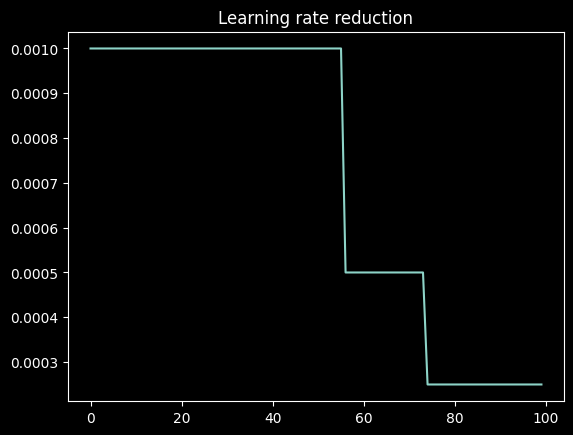

In [71]:
plt.title('Learning rate reduction')
plt.plot(lr)

Plot Loss, Acc

In [72]:
ep=[i for i in range(1, CFG['EPOCHS']+1)]

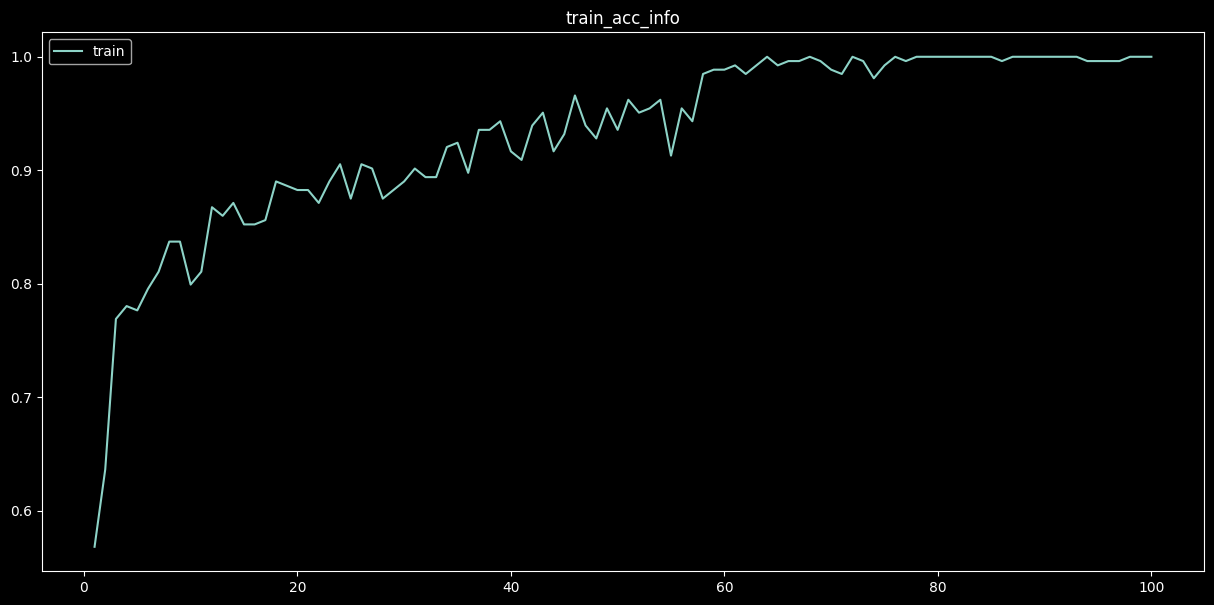

In [73]:
plt.figure(figsize=(15,7))
plt.title('train_acc_info')
plt.plot(ep, train_acc_info, label='train')
plt.legend()

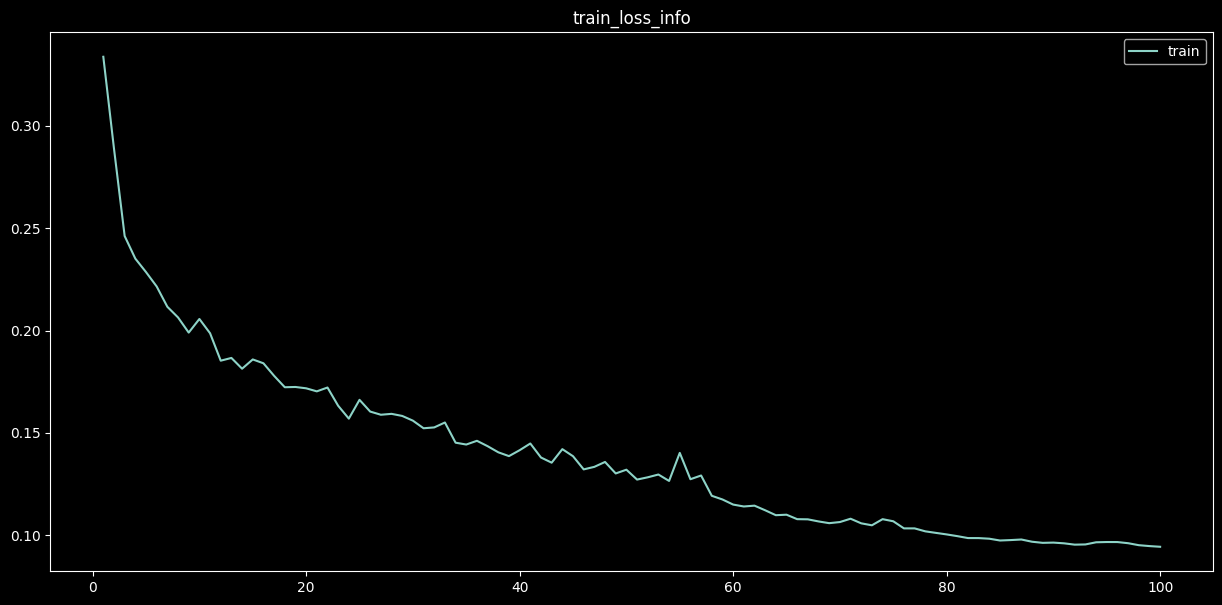

In [74]:
plt.figure(figsize=(15,7))
plt.title('train_loss_info')
plt.plot(ep, train_loss_info, label='train')
plt.legend()

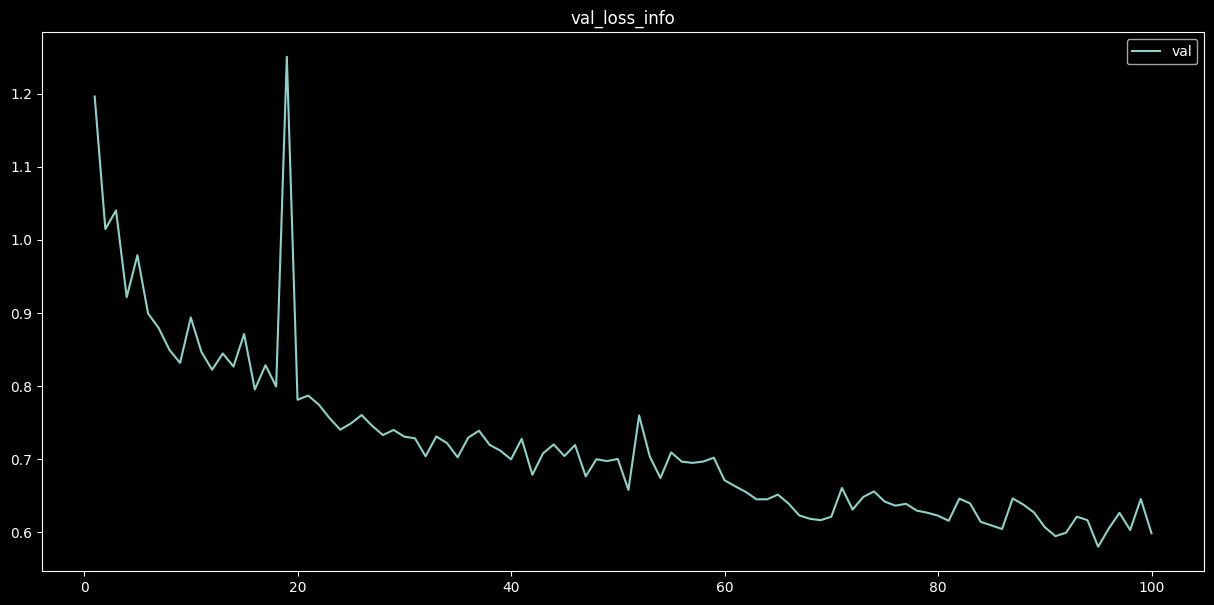

In [75]:
plt.figure(figsize=(15,7))
plt.title('val_loss_info')
plt.plot(ep,val_loss_info, label='val')
plt.legend()

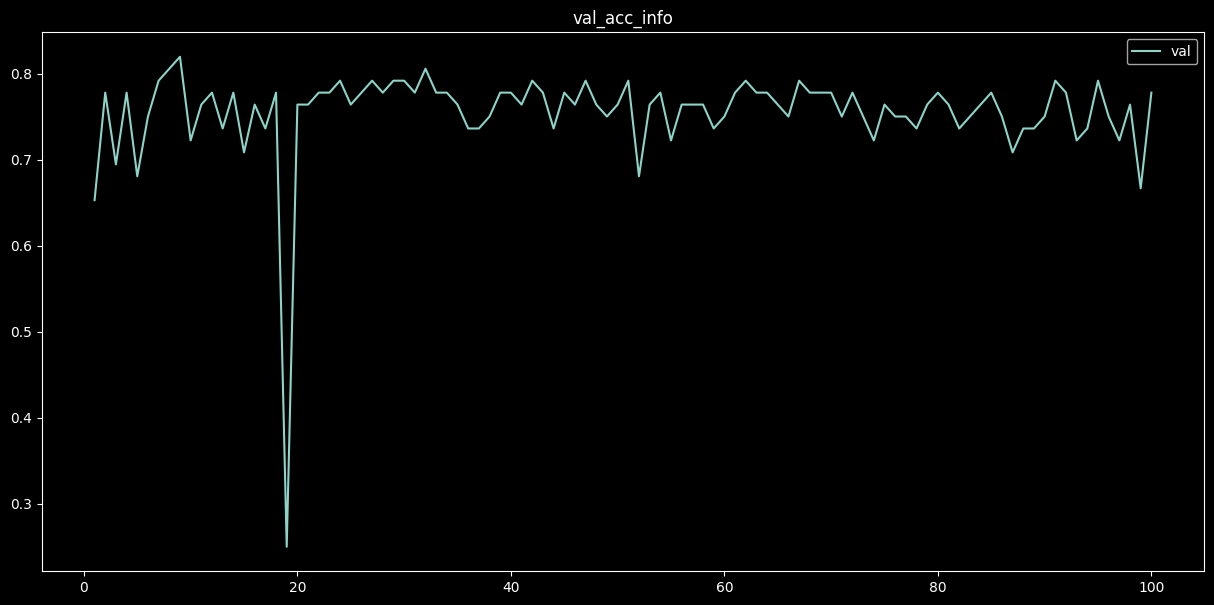

In [76]:
plt.figure(figsize=(15,7))
plt.title('val_acc_info')
plt.plot(ep,val_acc_info, label='val')
plt.legend()

# 12. Save Model

In [79]:
PATH='C:\\Users\\PC00\\Desktop\\ASD_data\\model\\_T1_T2\\'

In [80]:
torch.save(model, PATH+'model.pt') #전체 모델 저장
torch.save(model.state_dict(), PATH+'model_state_dict.pt') #모델 객체의 state_dict 저장
torch.save({
    'model':model.state_dict(),
    'optimizer':optimizer.state_dict()
}, PATH+'all.tar') #여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar 값 저장 가능

# 13. Test

In [81]:
model=torch.load(PATH+'model.pt') #전체 모델을 통째로 불러옴
model.load_state_dict(torch.load(PATH+'model_state_dict.pt')) #state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

model.to(device)

feature_model(
  (resnet): ResNet18(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (cbam): CBAM(
          (ChannelGate): ChannelGate(
            (mlp): Sequential(
              (0): Flatten()
 

In [82]:
#sensitivity
#양성인 것중에 양성으로 판별

#specificity
#음성인 것중에 음성으로 판별

def true_positive(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==1 and p[i]==1:
            cnt+=1
            
    return cnt


def true_negative(p,t):
    l=len(p)
    cnt=0
    for i in range(l):
        if t[i]==0 and p[i]==0:
            cnt+=1
    
    return cnt

In [83]:
def test_loop(dataloader,model, loss_fn, test_asd, test_tc):
    size=len(dataloader.dataset)
    num_batches=len(dataloader)
    model.eval()
    
    test_loss, correct=0,0
    
    TP,TN=0,0
    
    with torch.no_grad():
        for X1,X2,y in dataloader:
            X1=Variable(X1.to(device).float())
            X2=Variable(X2.to(device).float())
            y=Variable(y.to(device).float())
            
            pred=model(X1, X2)
            
            #loss
            test_loss+=loss_fn(pred, y).item()
            #accuracy
            correct+=(pred.argmax(1)==y.argmax(1)).type(torch.float).sum().item()
            print(f"Pred : {pred.argmax(1)}")
            print(f"True : {y.argmax(1)}")
            print()
            TP+=true_positive(pred.argmax(1), y.argmax(1))
            TN+=true_negative(pred.argmax(1), y.argmax(1))
    
    FN=test_asd-TP
    FP=test_tc-TN
    test_loss/=num_batches
    correct/=size
    
    print(f"Test Error\n Accuracy : {(100*correct):>0.1f}%, Avg Loss : {test_loss:>8f}\n")
    print(f"True Positive : {TP}\nTrue Negative : {TN}\nFalse Positive : {FP}\nFalse Negative : {FN}\n")
    return (TP/(TP+FN))*100, (TN/(FP+TN))*100, (TP/(TP+FP))*100, (TN/(FN+TN))*100

In [96]:
test_asdn=25
test_tcn=19

start=time.time()

sensitivity, specificity, PPV, NPV=test_loop(test_dataloader ,model, loss_fn, test_asdn, test_tcn)

end=time.time()

print(f"Test 걸린 시간 : {(end-start)//60} 분 {(end-start)%60:.1f} 초")

Pred : tensor([1, 0, 1, 0], device='cuda:0')
True : tensor([1, 1, 1, 1], device='cuda:0')

Pred : tensor([1, 0, 0, 0], device='cuda:0')
True : tensor([0, 0, 1, 0], device='cuda:0')

Pred : tensor([0, 1, 1, 1], device='cuda:0')
True : tensor([1, 1, 0, 1], device='cuda:0')

Pred : tensor([0, 1, 1, 1], device='cuda:0')
True : tensor([1, 0, 0, 0], device='cuda:0')

Pred : tensor([0, 1, 1, 1], device='cuda:0')
True : tensor([0, 0, 0, 1], device='cuda:0')

Pred : tensor([1, 0, 1, 0], device='cuda:0')
True : tensor([1, 0, 1, 1], device='cuda:0')

Pred : tensor([1, 1, 1, 1], device='cuda:0')
True : tensor([1, 1, 1, 1], device='cuda:0')

Pred : tensor([1, 1, 1, 1], device='cuda:0')
True : tensor([0, 0, 1, 1], device='cuda:0')

Pred : tensor([1, 1, 1, 1], device='cuda:0')
True : tensor([0, 1, 1, 1], device='cuda:0')

Pred : tensor([1, 1, 1, 1], device='cuda:0')
True : tensor([0, 0, 0, 1], device='cuda:0')

Pred : tensor([0, 1, 1, 1], device='cuda:0')
True : tensor([0, 1, 0, 1], device='cuda:0')


In [95]:
print(f"Sensitivity : {sensitivity:.3f}%")
print(f"Specificity : {specificity:.3f}%")
print(f"PPV : {PPV:.3f}%")
print(f"NPV : {NPV:.3f}%")

Sensitivity : 76.000%
Specificity : 26.316%
PPV : 57.576%
NPV : 45.455%
